In [298]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\visha\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8


In [299]:
import numpy as np 
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier #1)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB

from pgmpy.models import BayesianNetwork

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report 
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tqdm import tqdm

In [300]:
subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))] 
if len(subfolders) == 1: 
    path = os.path.join(path, subfolders[0]) 
print("Dataset folder with class subfolders:", path)
print("Classes found:", os.listdir(path))

Dataset folder with class subfolders: C:\Users\visha\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8\garbage-dataset
Classes found: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [301]:
img_size = (128,128)
X,y = [],[]

In [302]:
subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
if len(subfolders) == 1:
    path = os.path.join(path, subfolders[0])

print("Loading images...")
for class_name in os.listdir(path):
    class_folder = os.path.join(path, class_name)
    if not os.path.isdir(class_folder):
        continue
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        try:
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(class_name)
        except:
            continue

X = np.array(X)
y = np.array(y)
print("Dataset loaded:", X.shape, "labels:", len(np.unique(y)))

Loading images...
Dataset loaded: (19762, 128, 128, 3) labels: 10


In [303]:
X = preprocess_input(X) 
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y)

In [304]:
dump(label_encoder, "models/label_encoder.joblib")

['models/label_encoder.joblib']

In [305]:
X_train, X_test, y_train, y_test = train_test_split( X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(128, 128, 3)) 
X_train_feat = base_model.predict(X_train, batch_size=32, verbose=1) 
X_test_feat = base_model.predict(X_test, batch_size=32, verbose=1) 
print("Feature shape:", X_train_feat.shape)

495/495 ━━━━━━━━━━━━━━━━━━━━ 260s 518ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 47s 377ms/step
Feature shape: (15809, 1280)


In [306]:
import time
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [307]:
from joblib import dump

In [308]:
def evaluate_model(reg, X_test_feat, y_test, label_encoder, training_time, model_name="Model"):
    start_time = time.time()
    y_pred = reg.predict(X_test_feat) 
    prediction_time = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    per_class_acc = {}
    for i, class_name in enumerate(label_encoder.classes_):
      class_mask = (y_test == i)
      if np.sum(class_mask) > 0:
        class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
        per_class_acc[class_name] = class_acc
    roc_auc = None
    if hasattr(reg, 'predict_proba'):
        y_proba = reg.predict_proba(X_test_feat)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print("="*50)
    print(f"MODEL COMPARISON: {model_name}")
    print("="*50)
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:     {roc_auc:.4f}")
    print(f"Train Time:  {training_time:.2f}s")
    print(f"Pred Time:   {prediction_time:.2f}s")
    print(f"Speed:       {len(X_test_feat)/prediction_time:.0f} samples/s")
    print("\nPer-Class Accuracy (worst to best):")
    for class_name, acc in sorted(per_class_acc.items(), key=lambda x: x[1]):
      print(f"  {class_name:12}: {acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'prediction_time': prediction_time
    }
    

In [309]:
def confusion(reg,X_test_feat,y_test,model_name='Model'):
    y_pred = reg.predict(X_test_feat) 
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                      display_labels=label_encoder.classes_,
                                      cmap='Blues',
                                      xticks_rotation=45)
    plt.title(f'Confusion Matrix ({model_name})')
    plt.tight_layout()
    plt.show()

In [310]:
print("Training Logistic Regression...")
reg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=2000,class_weight='balanced',random_state=42)
start_time = time.time()
reg.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Logistic Regression...


In [311]:
evaluate_model(reg, X_test_feat, y_test, label_encoder, training_time, "Logistic Regression")

MODEL COMPARISON: Logistic Regression
Accuracy:    0.9092
Macro F1:    0.8913
Weighted F1: 0.9095
ROC-AUC:     0.9931
Train Time:  21.18s
Pred Time:   0.05s
Speed:       79533 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.8042
  plastic     : 0.8539
  metal       : 0.8676
  glass       : 0.8693
  paper       : 0.8750
  cardboard   : 0.9041
  battery     : 0.9206
  biological  : 0.9296
  shoes       : 0.9419
  clothes     : 0.9737

Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.92      0.93       189
  biological       0.95      0.93      0.94       199
   cardboard       0.89      0.90      0.90       365
     clothes       0.98      0.97      0.98      1066
       glass       0.91      0.87      0.89       612
       metal       0.79      0.87      0.83       204
       paper       0.85      0.88      0.86       336
     plastic       0.83      0.85      0.84       397
       shoes       0.92      0.94   

{'accuracy': 0.9091828990640021,
 'macro_f1': 0.891327997612299,
 'weighted_f1': 0.9095125490805427,
 'roc_auc': 0.9930683219186814,
 'training_time': 21.17772150039673,
 'prediction_time': 0.04970240592956543}

<Figure size 1000x800 with 0 Axes>

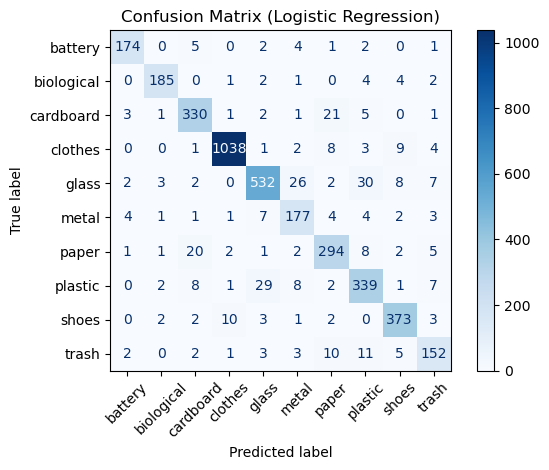

In [312]:
confusion(reg,X_test_feat,y_test,"Logistic Regression")

In [375]:
print("Training SVM...")
svm = SVC(kernel='rbf',C=1.0,gamma='scale',random_state=42,class_weight='balanced',probability=True)
start_time = time.time()
svm.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training SVM...


In [376]:
evaluate_model(svm, X_test_feat, y_test, label_encoder, training_time, "SVM")

MODEL COMPARISON: SVM
Accuracy:    0.9365
Macro F1:    0.9240
Weighted F1: 0.9366
ROC-AUC:     0.9963
Train Time:  1206.56s
Pred Time:   123.12s
Speed:       32 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.8730
  glass       : 0.8758
  plastic     : 0.8816
  paper       : 0.9256
  cardboard   : 0.9315
  battery     : 0.9418
  metal       : 0.9510
  biological  : 0.9548
  shoes       : 0.9798
  clothes     : 0.9850

Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.94      0.94       189
  biological       0.94      0.95      0.95       199
   cardboard       0.94      0.93      0.94       365
     clothes       0.99      0.98      0.99      1066
       glass       0.92      0.88      0.90       612
       metal       0.82      0.95      0.88       204
       paper       0.93      0.93      0.93       336
     plastic       0.90      0.88      0.89       397
       shoes       0.95      0.98      0.97       3

{'accuracy': 0.936503921072603,
 'macro_f1': 0.9240329327895539,
 'weighted_f1': 0.9365800214484711,
 'roc_auc': 0.9962556355115838,
 'training_time': 1206.5620021820068,
 'prediction_time': 123.12234234809875}

<Figure size 1000x800 with 0 Axes>

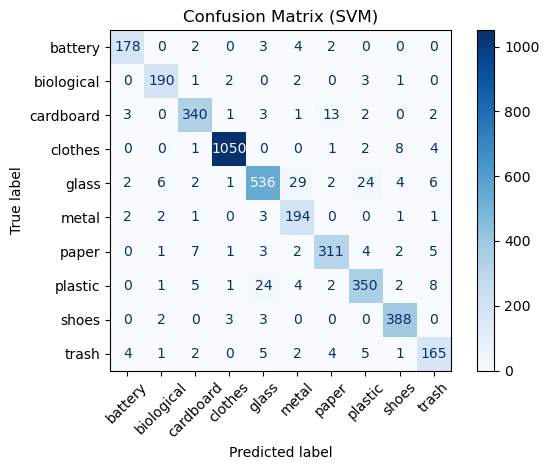

In [377]:
confusion(svm,X_test_feat,y_test,"SVM")

[9 0 2 4 2]
['trash' 'battery' 'cardboard' 'glass' 'cardboard']
<class 'sklearn.svm._classes.SVC'>
(3953, 10)


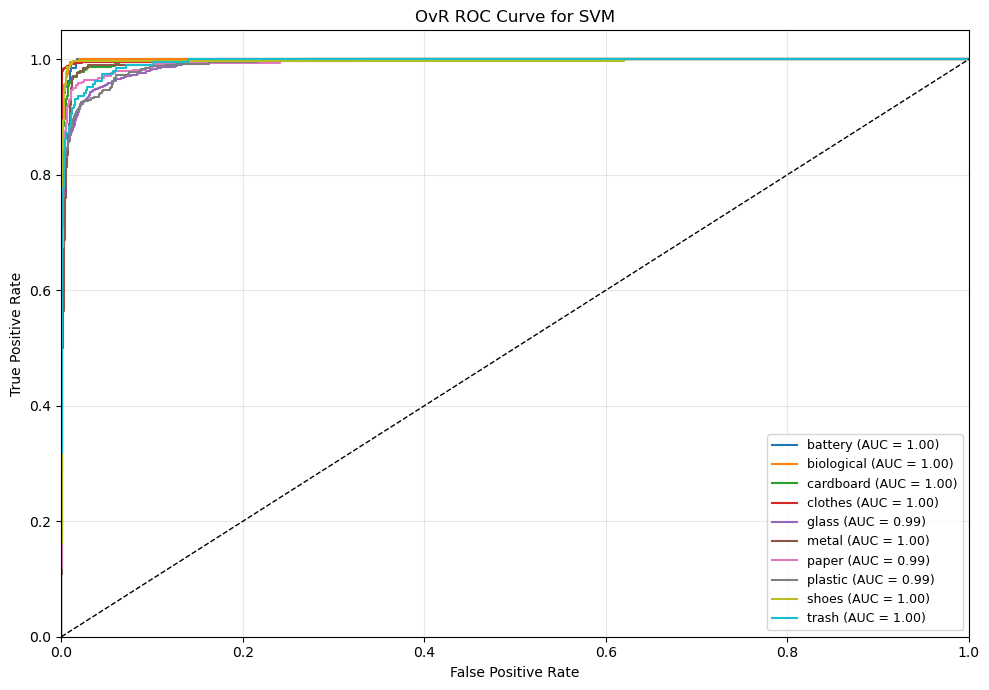

In [380]:
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
               'metal', 'paper', 'plastic', 'shoes', 'trash']


y_test_decoded = label_encoder.inverse_transform(y_test)
y_test_bin = label_binarize(y_test_decoded, classes=class_names)
n_classes = y_test_bin.shape[1]
print(y_test[:5])  
print(y_test_decoded[:5]) 
print(type(svm))

y_score = svm.predict_proba(X_test_feat)
print(y_score.shape) 

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves with categorical labels
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    label = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    plt.plot(fpr[i], tpr[i], label=label)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OvR ROC Curve for SVM')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig5.png', dpi=300)
plt.show()

In [316]:
print("Training Naive Bayes...")
nb = ComplementNB(alpha=0.1,norm=False,fit_prior=True)
start_time = time.time()
nb.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Naive Bayes...


In [317]:
evaluate_model(nb, X_test_feat, y_test, label_encoder, training_time, "Naive Bayes")

MODEL COMPARISON: Naive Bayes
Accuracy:    0.7625
Macro F1:    0.6685
Weighted F1: 0.7364
ROC-AUC:     0.9580
Train Time:  0.63s
Pred Time:   0.09s
Speed:       45717 samples/s

Per-Class Accuracy (worst to best):
  metal       : 0.1667
  trash       : 0.1799
  plastic     : 0.5365
  paper       : 0.5774
  battery     : 0.6402
  cardboard   : 0.7671
  biological  : 0.8442
  glass       : 0.8824
  shoes       : 0.9520
  clothes     : 0.9878

Classification Report:
              precision    recall  f1-score   support

     battery       0.85      0.64      0.73       189
  biological       0.93      0.84      0.88       199
   cardboard       0.65      0.77      0.70       365
     clothes       0.82      0.99      0.89      1066
       glass       0.67      0.88      0.76       612
       metal       0.79      0.17      0.28       204
       paper       0.73      0.58      0.65       336
     plastic       0.79      0.54      0.64       397
       shoes       0.77      0.95      0.85  

{'accuracy': 0.7624588919807741,
 'macro_f1': 0.6684642155750982,
 'weighted_f1': 0.7363663637449491,
 'roc_auc': 0.9579989297708291,
 'training_time': 0.6280229091644287,
 'prediction_time': 0.08646655082702637}

<Figure size 1000x800 with 0 Axes>

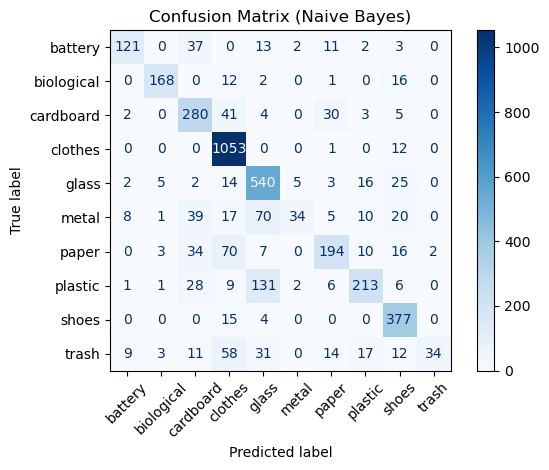

In [318]:
confusion(nb,X_test_feat,y_test,"Naive Bayes")

In [319]:
print("Training KNN...") 
knn = KNeighborsClassifier(n_neighbors=5, weights="distance",algorithm='auto',leaf_size=30,p=2,metric='minkowski')
start_time = time.time()
knn.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training KNN...


In [320]:
evaluate_model(knn, X_test_feat, y_test, label_encoder, training_time, "KNN")

MODEL COMPARISON: KNN
Accuracy:    0.9226
Macro F1:    0.9088
Weighted F1: 0.9221
ROC-AUC:     0.9811
Train Time:  0.04s
Pred Time:   5.90s
Speed:       670 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.8307
  plastic     : 0.8438
  metal       : 0.8578
  paper       : 0.8780
  glass       : 0.9052
  cardboard   : 0.9096
  battery     : 0.9153
  biological  : 0.9548
  shoes       : 0.9697
  clothes     : 0.9869

Classification Report:
              precision    recall  f1-score   support

     battery       0.90      0.92      0.91       189
  biological       0.93      0.95      0.94       199
   cardboard       0.92      0.91      0.92       365
     clothes       0.97      0.99      0.98      1066
       glass       0.88      0.91      0.89       612
       metal       0.87      0.86      0.86       204
       paper       0.89      0.88      0.89       336
     plastic       0.91      0.84      0.87       397
       shoes       0.94      0.97      0.95       396
 

{'accuracy': 0.922590437642297,
 'macro_f1': 0.908838412650925,
 'weighted_f1': 0.9221338514910596,
 'roc_auc': 0.9811267232913214,
 'training_time': 0.04424023628234863,
 'prediction_time': 5.897777557373047}

<Figure size 1000x800 with 0 Axes>

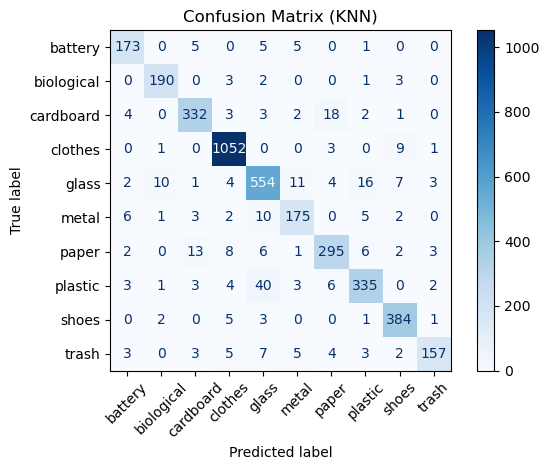

In [321]:
confusion(knn,X_test_feat,y_test,"KNN")

In [322]:
print('Training Desicion Tree...')
dtc = DecisionTreeClassifier(max_depth=25,min_samples_split=5,min_samples_leaf=3,max_features=0.5,criterion='gini',class_weight='balanced',random_state=42)
start_time = time.time()
dtc.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Desicion Tree...


In [323]:
evaluate_model(dtc, X_test_feat, y_test, label_encoder, training_time, "Decision Tree Classifier")

MODEL COMPARISON: Decision Tree Classifier
Accuracy:    0.6420
Macro F1:    0.5827
Weighted F1: 0.6483
ROC-AUC:     0.7945
Train Time:  45.27s
Pred Time:   0.02s
Speed:       158341 samples/s

Per-Class Accuracy (worst to best):
  metal       : 0.4265
  trash       : 0.4286
  paper       : 0.5446
  plastic     : 0.5516
  battery     : 0.6032
  cardboard   : 0.6247
  glass       : 0.6258
  biological  : 0.6683
  shoes       : 0.6793
  clothes     : 0.7889

Classification Report:
              precision    recall  f1-score   support

     battery       0.51      0.60      0.55       189
  biological       0.59      0.67      0.62       199
   cardboard       0.61      0.62      0.62       365
     clothes       0.89      0.79      0.83      1066
       glass       0.66      0.63      0.64       612
       metal       0.38      0.43      0.40       204
       paper       0.51      0.54      0.53       336
     plastic       0.55      0.55      0.55       397
       shoes       0.72      0

{'accuracy': 0.642044017202125,
 'macro_f1': 0.5827479383011276,
 'weighted_f1': 0.6483167099766832,
 'roc_auc': 0.7944577375292868,
 'training_time': 45.27251195907593,
 'prediction_time': 0.02496504783630371}

<Figure size 1000x800 with 0 Axes>

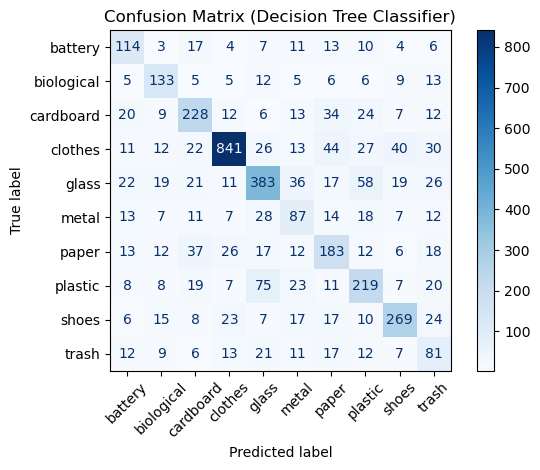

In [324]:
confusion(dtc,X_test_feat,y_test,"Decision Tree Classifier")

In [325]:
print('Training Random forest...')
rf = RandomForestClassifier(n_estimators=200,max_depth=25,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',class_weight='balanced',
                            bootstrap=True,random_state=42)
start_time = time.time()
rf.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Random forest...


In [326]:
evaluate_model(rf, X_test_feat, y_test, label_encoder, training_time, "Random Forest Classifier")

MODEL COMPARISON: Random Forest Classifier
Accuracy:    0.8836
Macro F1:    0.8594
Weighted F1: 0.8810
ROC-AUC:     0.9896
Train Time:  209.53s
Pred Time:   2.08s
Speed:       1900 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.6455
  metal       : 0.6569
  plastic     : 0.7909
  paper       : 0.8214
  cardboard   : 0.8795
  battery     : 0.8836
  glass       : 0.8840
  biological  : 0.9347
  shoes       : 0.9621
  clothes     : 0.9859

Classification Report:
              precision    recall  f1-score   support

     battery       0.91      0.88      0.90       189
  biological       0.92      0.93      0.93       199
   cardboard       0.87      0.88      0.88       365
     clothes       0.92      0.99      0.95      1066
       glass       0.82      0.88      0.85       612
       metal       0.83      0.66      0.73       204
       paper       0.84      0.82      0.83       336
     plastic       0.87      0.79      0.83       397
       shoes       0.90      0.

{'accuracy': 0.8836326840374399,
 'macro_f1': 0.85937682822288,
 'weighted_f1': 0.8810286563333319,
 'roc_auc': 0.9896129287832706,
 'training_time': 209.5343017578125,
 'prediction_time': 2.0810232162475586}

<Figure size 1000x800 with 0 Axes>

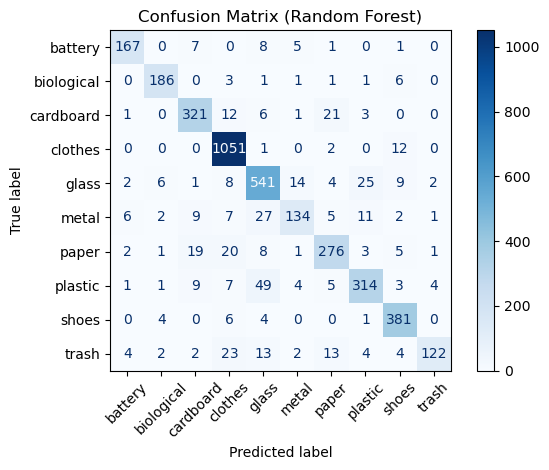

In [327]:
confusion(rf,X_test_feat,y_test,"Random Forest")

In [328]:
print('Training XG Boost Classifier...')
xg = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=8,subsample=0.8, colsample_bytree=0.8,
                   reg_alpha=0.1, reg_lambda=0.1, eval_metric='mlogloss', random_state=42)
start_time = time.time()
xg.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training XG Boost Classifier...


In [329]:
evaluate_model(xg, X_test_feat, y_test, label_encoder, training_time, "XG Boost Classifier")

MODEL COMPARISON: XG Boost Classifier
Accuracy:    0.9130
Macro F1:    0.8938
Weighted F1: 0.9122
ROC-AUC:     0.9941
Train Time:  1558.37s
Pred Time:   0.59s
Speed:       6731 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.7778
  metal       : 0.7843
  plastic     : 0.8438
  paper       : 0.8690
  glass       : 0.8938
  battery     : 0.8942
  cardboard   : 0.9260
  biological  : 0.9397
  shoes       : 0.9621
  clothes     : 0.9878

Classification Report:
              precision    recall  f1-score   support

     battery       0.92      0.89      0.91       189
  biological       0.93      0.94      0.93       199
   cardboard       0.91      0.93      0.92       365
     clothes       0.96      0.99      0.97      1066
       glass       0.88      0.89      0.89       612
       metal       0.83      0.78      0.81       204
       paper       0.89      0.87      0.88       336
     plastic       0.87      0.84      0.86       397
       shoes       0.93      0.96  

{'accuracy': 0.9129774854540855,
 'macro_f1': 0.8937584342514766,
 'weighted_f1': 0.9121825378203086,
 'roc_auc': 0.9940608578816172,
 'training_time': 1558.3651502132416,
 'prediction_time': 0.5873136520385742}

<Figure size 1000x800 with 0 Axes>

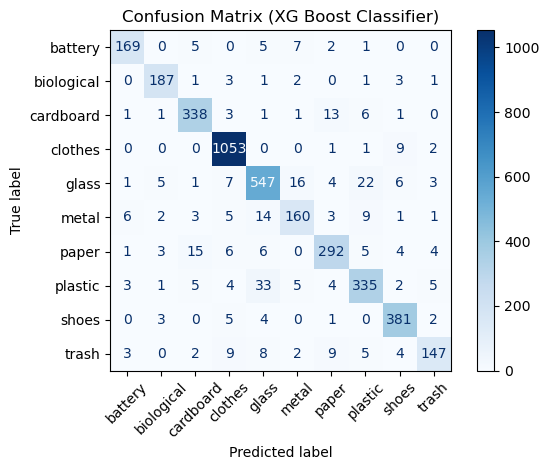

In [330]:
confusion(xg,X_test_feat,y_test,"XG Boost Classifier")

In [331]:
print('Training Ada Boost Classifier...')
base_estimator = DecisionTreeClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=5,max_features='sqrt',random_state=42)
ad = AdaBoostClassifier(estimator=base_estimator,n_estimators=150,learning_rate=0.3,random_state=42)
start_time = time.time()
ad.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Ada Boost Classifier...


In [332]:
evaluate_model(ad, X_test_feat, y_test, label_encoder, training_time, "Ada Boost Classifier")

MODEL COMPARISON: Ada Boost Classifier
Accuracy:    0.9003
Macro F1:    0.8780
Weighted F1: 0.8996
ROC-AUC:     0.9877
Train Time:  184.29s
Pred Time:   1.70s
Speed:       2320 samples/s

Per-Class Accuracy (worst to best):
  metal       : 0.7010
  trash       : 0.7354
  plastic     : 0.8388
  battery     : 0.8730
  paper       : 0.8839
  cardboard   : 0.8904
  glass       : 0.9069
  biological  : 0.9095
  shoes       : 0.9318
  clothes     : 0.9869

Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.87      0.91       189
  biological       0.95      0.91      0.93       199
   cardboard       0.92      0.89      0.91       365
     clothes       0.96      0.99      0.98      1066
       glass       0.83      0.91      0.87       612
       metal       0.83      0.70      0.76       204
       paper       0.84      0.88      0.86       336
     plastic       0.84      0.84      0.84       397
       shoes       0.93      0.93  

{'accuracy': 0.9003288641538072,
 'macro_f1': 0.8779648585008507,
 'weighted_f1': 0.8995652778822184,
 'roc_auc': 0.9877452340217822,
 'training_time': 184.29136300086975,
 'prediction_time': 1.7039856910705566}

<Figure size 1000x800 with 0 Axes>

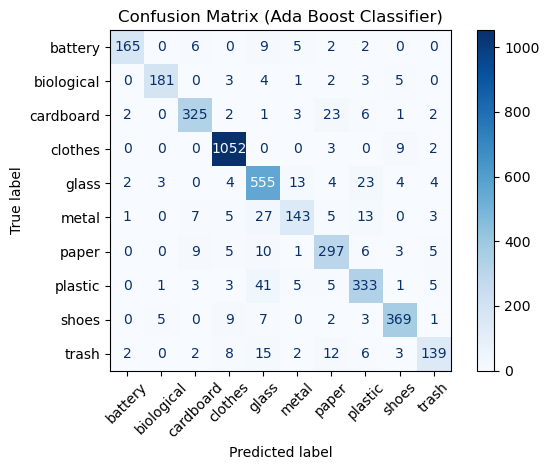

In [333]:
confusion(ad,X_test_feat,y_test,"Ada Boost Classifier")

In [334]:
print('Training Multi-Layer Perceptron...')
clf = MLPClassifier(hidden_layer_sizes=(512,256,128), activation='relu', solver='adam', max_iter=500, alpha=0.0005, 
                   learning_rate='adaptive',learning_rate_init=0.001,early_stopping=True,validation_fraction=0.1,n_iter_no_change=15,
                   random_state=42)
start_time = time.time()
clf.fit(X_train_feat,y_train)
training_time = time.time() - start_time

Training Multi-Layer Perceptron...


In [335]:
evaluate_model(clf, X_test_feat, y_test, label_encoder, training_time, "Multi Layer Perceptron")

MODEL COMPARISON: Multi Layer Perceptron
Accuracy:    0.9256
Macro F1:    0.9094
Weighted F1: 0.9257
ROC-AUC:     0.9956
Train Time:  189.75s
Pred Time:   0.36s
Speed:       11021 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.8360
  plastic     : 0.8589
  metal       : 0.8775
  glass       : 0.8954
  paper       : 0.9048
  battery     : 0.9206
  cardboard   : 0.9315
  biological  : 0.9347
  shoes       : 0.9672
  clothes     : 0.9812

Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.92      0.93       189
  biological       0.94      0.93      0.94       199
   cardboard       0.91      0.93      0.92       365
     clothes       0.99      0.98      0.98      1066
       glass       0.91      0.90      0.90       612
       metal       0.82      0.88      0.85       204
       paper       0.90      0.90      0.90       336
     plastic       0.88      0.86      0.87       397
       shoes       0.94      0.9

{'accuracy': 0.9256261067543637,
 'macro_f1': 0.9094331193399515,
 'weighted_f1': 0.9256512023632719,
 'roc_auc': 0.9956384041313932,
 'training_time': 189.7476179599762,
 'prediction_time': 0.35867977142333984}

<Figure size 1000x800 with 0 Axes>

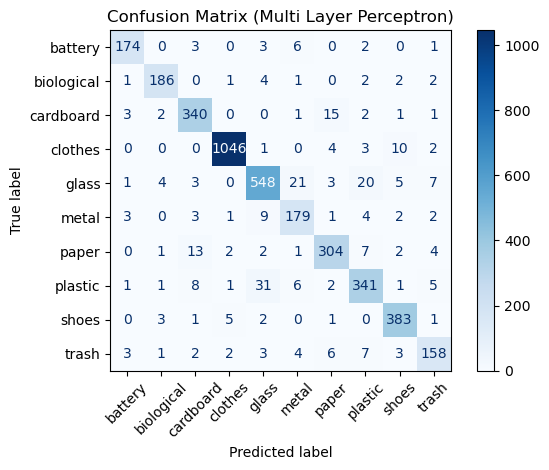

In [336]:
confusion(clf,X_test_feat,y_test,"Multi Layer Perceptron")

In [337]:
import numpy as np
import pandas as pd
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score
from pgmpy.estimators import HillClimbSearch, BIC,AIC
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination

In [338]:
K = 75
selector = SelectKBest(score_func=f_classif, k=K)

X_train_reduced = selector.fit_transform(X_train_feat, y_train)
X_test_reduced = selector.transform(X_test_feat)

feature_cols = [f'f{i}' for i in range(K)]
train_df = pd.DataFrame(X_train_reduced, columns=feature_cols)
test_df = pd.DataFrame(X_test_reduced, columns=feature_cols)
train_df['target'] = y_train
test_df['target'] = y_test

In [339]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

X_train_discrete = discretizer.fit_transform(train_df.drop(columns=['target']))
X_test_discrete = discretizer.transform(test_df.drop(columns=['target']))

train_df_discrete = pd.DataFrame(X_train_discrete, columns=feature_cols).astype(int)
test_df_discrete = pd.DataFrame(X_test_discrete, columns=feature_cols).astype(int)

target_node_name = 'target'
train_df_discrete[target_node_name] = train_df[target_node_name].astype(int)
test_df_discrete[target_node_name] = test_df[target_node_name].astype(int)

In [340]:

for col in train_df_discrete.columns:
    train_df_discrete[col] = train_df_discrete[col].astype('category')
for col in test_df_discrete.columns:
    test_df_discrete[col] = test_df_discrete[col].astype('category')


print(f"\nLearning BN structure with {K} nodes (Hill Climb Search)...")
start_train = time.time()
aic_scorer = AIC(data=train_df_discrete)
hc = HillClimbSearch(data=train_df_discrete)

bn_structure = hc.estimate(scoring_method= aic_scorer, max_indegree=3) 


bn_model = DiscreteBayesianNetwork(bn_structure.edges())

if target_node_name not in bn_model.nodes():
    bn_model.add_node(target_node_name)
    print(f"Model Fix: Manually added '{target_node_name}' node to the DiscreteBayesianNetwork model.")

print("Fitting BN parameters (Maximum Likelihood)...")
estimator = BayesianEstimator(bn_model, train_df_discrete)

bn_model.fit(
    data=train_df_discrete,
    estimator=BayesianEstimator,
    prior_type='dirichlet',
    pseudo_counts= 0.15
)
training_time = time.time() - start_train

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'f0': 'C', 'f1': 'C', 'f2': 'C', 'f3': 'C', 'f4': 'C', 'f5': 'C', 'f6': 'C', 'f7': 'C', 'f8': 'C', 'f9': 'C', 'f10': 'C', 'f11': 'C', 'f12': 'C', 'f13': 'C', 'f14': 'C', 'f15': 'C', 'f16': 'C', 'f17': 'C', 'f18': 'C', 'f19': 'C', 'f20': 'C', 'f21': 'C', 'f22': 'C', 'f23': 'C', 'f24': 'C', 'f25': 'C', 'f26': 'C', 'f27': 'C', 'f28': 'C', 'f29': 'C', 'f30': 'C', 'f31': 'C', 'f32': 'C', 'f33': 'C', 'f34': 'C', 'f35': 'C', 'f36': 'C', 'f37': 'C', 'f38': 'C', 'f39': 'C', 'f40': 'C', 'f41': 'C', 'f42': 'C', 'f43': 'C', 'f44': 'C', 'f45': 'C', 'f46': 'C', 'f47': 'C', 'f48': 'C', 'f49': 'C', 'f50': 'C', 'f51': 'C', 'f52': 'C', 'f53': 'C', 'f54': 'C', 'f55': 'C', 'f56': 'C', 'f57': 'C', 'f58': 'C', 'f59': 'C', 'f60': 'C', 'f61': 'C', 'f62': 'C', 'f63': 'C', 'f64': 'C', 'f65': 'C', 'f66': 'C', 'f67': 'C', 'f68': 'C', 'f69': 'C', 'f70': 'C', 'f71': 'C', 'f72': 'C', 'f73': 'C', 'f74': 'C', 'tar


Learning BN structure with 75 nodes (Hill Climb Search)...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'f0': 'C', 'f1': 'C', 'f2': 'C', 'f3': 'C', 'f4': 'C', 'f5': 'C', 'f6': 'C', 'f7': 'C', 'f8': 'C', 'f9': 'C', 'f10': 'C', 'f11': 'C', 'f12': 'C', 'f13': 'C', 'f14': 'C', 'f15': 'C', 'f16': 'C', 'f17': 'C', 'f18': 'C', 'f19': 'C', 'f20': 'C', 'f21': 'C', 'f22': 'C', 'f23': 'C', 'f24': 'C', 'f25': 'C', 'f26': 'C', 'f27': 'C', 'f28': 'C', 'f29': 'C', 'f30': 'C', 'f31': 'C', 'f32': 'C', 'f33': 'C', 'f34': 'C', 'f35': 'C', 'f36': 'C', 'f37': 'C', 'f38': 'C', 'f39': 'C', 'f40': 'C', 'f41': 'C', 'f42': 'C', 'f43': 'C', 'f44': 'C', 'f45': 'C', 'f46': 'C', 'f47': 'C', 'f48': 'C', 'f49': 'C', 'f50': 'C', 'f51': 'C', 'f52': 'C', 'f53': 'C', 'f54': 'C', 'f55': 'C', 'f56': 'C', 'f57': 'C', 'f58': 'C', 'f59': 'C', 'f60': 'C', 'f61': 'C', 'f62': 'C', 'f63': 'C', 'f64': 'C', 'f65': 'C', 'f66': 'C', 'f67': 'C', 'f68': 'C', 'f69': 'C', 'f70': 'C', 'f71': 'C', 'f72': 'C', 'f73': 'C', 'f74': 'C', 'tar

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'f0': 'C', 'f1': 'C', 'f2': 'C', 'f3': 'C', 'f4': 'C', 'f5': 'C', 'f6': 'C', 'f7': 'C', 'f8': 'C', 'f9': 'C', 'f10': 'C', 'f11': 'C', 'f12': 'C', 'f13': 'C', 'f14': 'C', 'f15': 'C', 'f16': 'C', 'f17': 'C', 'f18': 'C', 'f19': 'C', 'f20': 'C', 'f21': 'C', 'f22': 'C', 'f23': 'C', 'f24': 'C', 'f25': 'C', 'f26': 'C', 'f27': 'C', 'f28': 'C', 'f29': 'C', 'f30': 'C', 'f31': 'C', 'f32': 'C', 'f33': 'C', 'f34': 'C', 'f35': 'C', 'f36': 'C', 'f37': 'C', 'f38': 'C', 'f39': 'C', 'f40': 'C', 'f41': 'C', 'f42': 'C', 'f43': 'C', 'f44': 'C', 'f45': 'C', 'f46': 'C', 'f47': 'C', 'f48': 'C', 'f49': 'C', 'f50': 'C', 'f51': 'C', 'f52': 'C', 'f53': 'C', 'f54': 'C', 'f55': 'C', 'f56': 'C', 'f57': 'C', 'f58': 'C', 'f59': 'C', 'f60': 'C', 'f61': 'C', 'f62': 'C', 'f63': 'C', 'f64': 'C', 'f65': 'C', 'f66': 'C', 'f67': 'C', 'f68': 'C', 'f69': 'C', 'f70': 'C', 'f71': 'C', 'f72': 'C', 'f73': 'C', 'f74': 'C', 'tar

Fitting BN parameters (Maximum Likelihood)...


In [341]:

print("\nPerforming Inference (Prediction) on ALL test samples...")
inference = VariableElimination(bn_model) 

def predict_bn(row, feature_columns):
    # Explicitly select only the feature columns for the evidence
    evidence_row = row[feature_columns].to_dict()
    query = inference.query(variables=['target'], evidence=evidence_row, show_progress=False)
    return np.argmax(query.values)

# Apply prediction function to the entire test set
start_pred = time.time()
y_pred_bn = test_df_discrete.apply(
    predict_bn, 
    axis=1, 
    args=(feature_cols,)
).values
prediction_time = time.time() - start_pred

y_test_bn = test_df_discrete['target'].cat.codes.values 
accuracy_bn = accuracy_score(y_test_bn, y_pred_bn)

print(f"Optimized Bayesian Network (K={K} Features):")
print(f"Accuracy (Full Test Set) = {accuracy_bn:.4f}")


Performing Inference (Prediction) on ALL test samples...
Optimized Bayesian Network (K=75 Features):
Accuracy (Full Test Set) = 0.7984


In [342]:
print("="*50)
print("MODEL COMPARISON: Bayesian Network")
print("="*50)

# Calculate all metrics
macro_f1_bn = f1_score(y_test_bn, y_pred_bn, average='macro')
weighted_f1_bn = f1_score(y_test_bn, y_pred_bn, average='weighted')

# For ROC-AUC - simplified version since BN probabilities are tricky
n_classes = len(np.unique(y_test_bn))
y_proba_bn = np.zeros((len(y_test_bn), n_classes))
for i, pred in enumerate(y_pred_bn):
    y_proba_bn[i, pred] = 1.0  # Simple one-hot encoding

try:
    roc_auc_bn = roc_auc_score(y_test_bn, y_proba_bn, multi_class='ovr', average='macro')
except:
    roc_auc_bn = 0.5  # Fallback

# Calculate per-class accuracy
cm = confusion_matrix(y_test_bn, y_pred_bn)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
               'metal', 'paper', 'plastic', 'shoes', 'trash']

print(f"Accuracy:    {accuracy_bn:.4f}")
print(f"Macro F1:    {macro_f1_bn:.4f}")
print(f"Weighted F1: {weighted_f1_bn:.4f}")
print(f"ROC-AUC:     {roc_auc_bn:.4f}")
print(f"Train Time:  {training_time:.2f}s")
print(f"Pred Time:   {prediction_time:.2f}s")
print(f"Speed:       {len(y_test_bn)/prediction_time:.0f} samples/s")

print("\nPer-Class Accuracy (worst to best):")
class_accuracy_pairs = sorted(zip(class_names, per_class_accuracy), key=lambda x: x[1])
for class_name, acc in class_accuracy_pairs:
    print(f"  {class_name:12}: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_bn, y_pred_bn, target_names=class_names))

bn_metrics = {
    'accuracy': accuracy_bn,
    'macro_f1': macro_f1_bn,
    'weighted_f1': weighted_f1_bn,
    'roc_auc': roc_auc_bn,
    'training_time': training_time,
    'prediction_time': prediction_time
}

print(f"\n{bn_metrics}")

MODEL COMPARISON: Bayesian Network
Accuracy:    0.7984
Macro F1:    0.7420
Weighted F1: 0.8001
ROC-AUC:     0.8638
Train Time:  206.73s
Pred Time:   33.57s
Speed:       118 samples/s

Per-Class Accuracy (worst to best):
  trash       : 0.5185
  metal       : 0.5882
  plastic     : 0.6574
  paper       : 0.6994
  cardboard   : 0.7616
  glass       : 0.7680
  battery     : 0.7725
  biological  : 0.8643
  shoes       : 0.9192
  clothes     : 0.9493

Classification Report:
              precision    recall  f1-score   support

     battery       0.74      0.77      0.76       189
  biological       0.77      0.86      0.82       199
   cardboard       0.80      0.76      0.78       365
     clothes       0.96      0.95      0.95      1066
       glass       0.82      0.77      0.80       612
       metal       0.47      0.59      0.52       204
       paper       0.69      0.70      0.70       336
     plastic       0.77      0.66      0.71       397
       shoes       0.87      0.92      

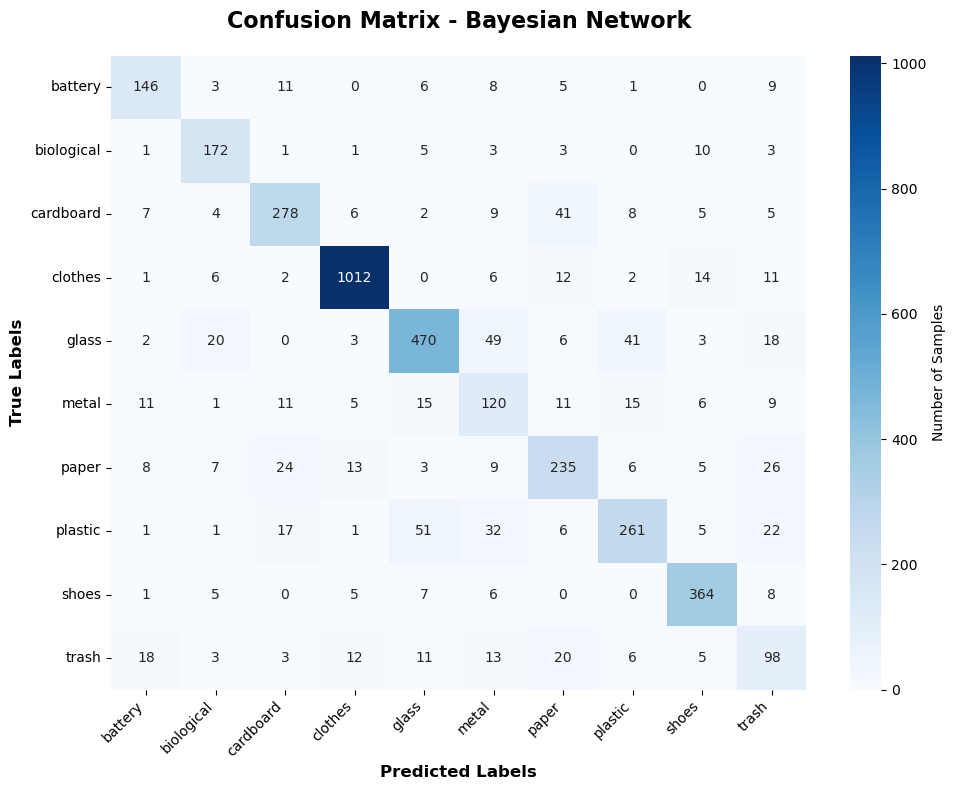

In [343]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create confusion matrix
cm = confusion_matrix(y_test_bn, y_pred_bn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix - Bayesian Network', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('fig6.png')
plt.show()


<Figure size 1000x800 with 0 Axes>

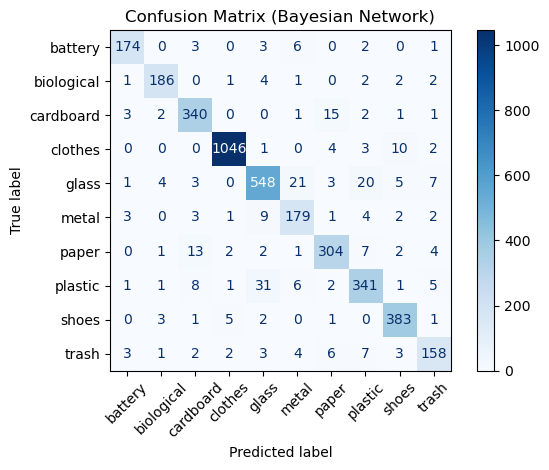

In [344]:
cm = confusion_matrix(y_test_bn, y_pred_bn)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                      display_labels=label_encoder.classes_,
                                      cmap='Blues',
                                      xticks_rotation=45)
plt.title(f'Confusion Matrix (Bayesian Network)')
plt.tight_layout()
plt.show()

In [345]:
macro_precision = precision_score(y_test_bn, y_pred_bn, average='macro', zero_division=0)
macro_recall = recall_score(y_test_bn, y_pred_bn, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.7375
Macro Recall : 0.7499


In [346]:
dump(reg, 'models/logistic_regression_model.joblib')
dump(svm, 'models/support_vector_machine_model.joblib')
dump(nb, 'models/naive_bayes_model.joblib')
dump(knn, 'models/KNeighbors_model.joblib')
dump(dtc, 'models/decision_tree_model.joblib')
dump(rf, 'models/random_forest_model.joblib')
dump(xg, 'models/xgboost_model.joblib')
dump(ad, 'models/adaboost_model.joblib')
dump(clf, 'models/neural_network_model.joblib')
dump(bn_model, 'models/bayesian_network_model.joblib')

['models/bayesian_network_model.joblib']

In [347]:
dump(selector, "models/selector.joblib")
dump(discretizer, "models/discretizer.joblib")
dump(feature_cols, "models/feature_cols.joblib")

['models/feature_cols.joblib']

In [348]:
from sklearn.metrics import precision_score, recall_score

In [349]:
y_pred = reg.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.8893
Macro Recall : 0.8940


In [350]:
y_pred = svm.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.9193
Macro Recall : 0.9300


In [351]:
y_pred = nb.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.7934
Macro Recall : 0.6534


In [352]:
y_pred = knn.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.9136
Macro Recall : 0.9052


In [353]:
y_pred = dtc.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.5749
Macro Recall : 0.5942


In [354]:
y_pred = rf.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.8827
Macro Recall : 0.8444


In [355]:
y_pred = xg.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.9008
Macro Recall : 0.8879


In [356]:
y_pred = ad.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.8933
Macro Recall : 0.8658


In [357]:
y_pred = clf.predict(X_test_feat)
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Macro Precision : {macro_precision:.4f}')
print(f'Macro Recall : {macro_recall:.4f}')

Macro Precision : 0.9085
Macro Recall : 0.9108


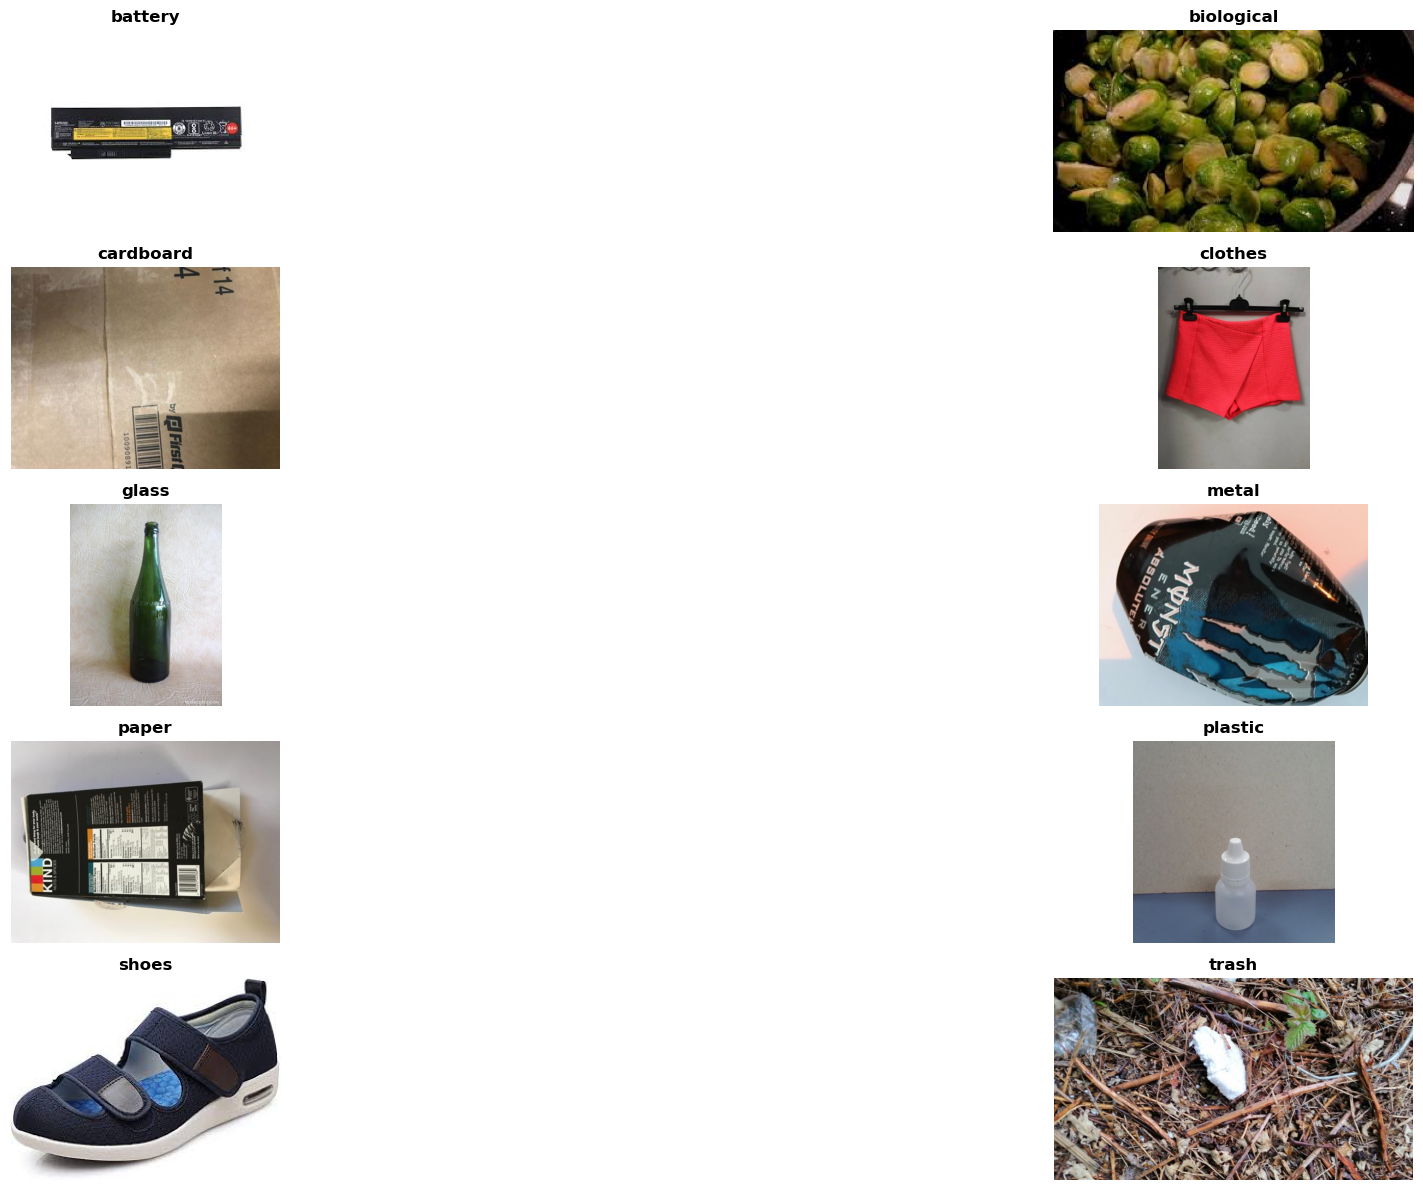

Figure 2 saved as figure2_class_samples.png


In [7]:
import matplotlib.pyplot as plt
import os
import random

def create_sample_images_grid(dataset_path, save_path="class_samples.png"):
    """
    Create a grid of sample images from each class for Figure 2
    """
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    
    fig, axes = plt.subplots(5, 2, figsize=(30,12))
    axes = axes.ravel()
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if images:
            # Randomly select one image from the class
            sample_img = random.choice(images)
            img_path = os.path.join(class_path, sample_img)
            
            # Load and display image
            img = plt.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 2 saved as {save_path}")

# Usage
dataset_path = r"C:\Users\visha\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8\garbage-dataset"
create_sample_images_grid(dataset_path, "figure2_class_samples.png")

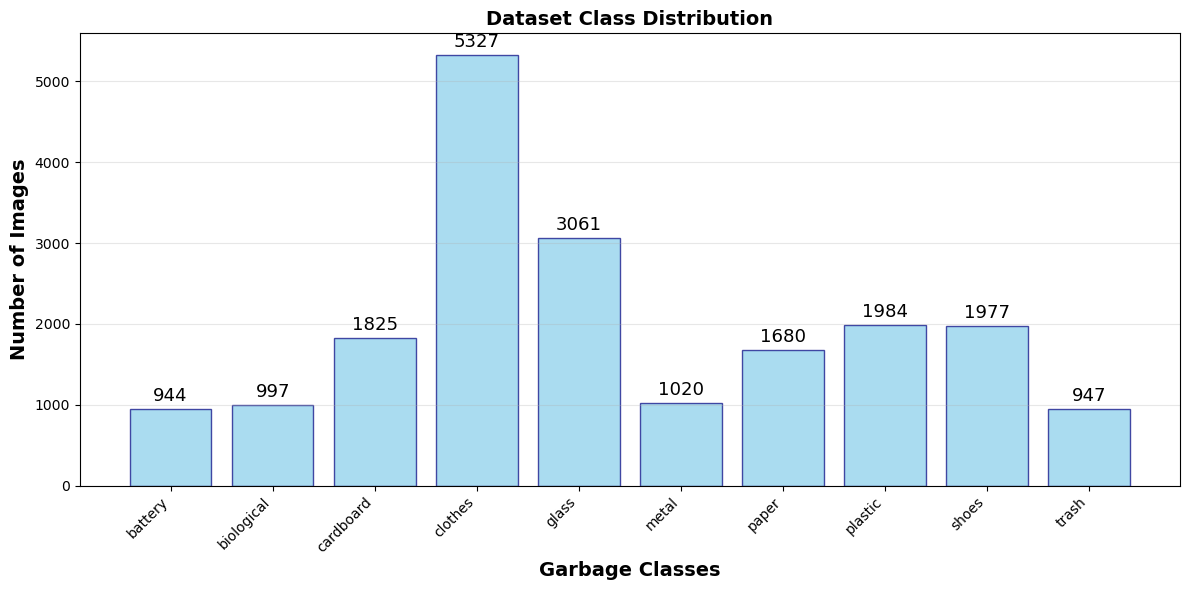

Class distribution chart saved as figure3_class_distribution.png


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_class_distribution_chart(class_counts, save_path="class_distribution.png"):
    """
    Create a bar chart showing number of samples per class
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{count}', ha='center', va='bottom', fontsize=13)
    
    plt.xlabel('Garbage Classes', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
    plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Class distribution chart saved as {save_path}")

# Your actual class distribution
class_distribution = {
    'battery': 944,
    'biological': 997, 
    'cardboard': 1825,
    'clothes': 5327,
    'glass': 3061,
    'metal': 1020,
    'paper': 1680,
    'plastic': 1984,
    'shoes': 1977,
    'trash': 947
}

create_class_distribution_chart(class_distribution, "figure3_class_distribution.png")

In [360]:
import sys
import sklearn
import pgmpy
import tensorflow as tf
import xgboost as xgb
print(f"Python version: {sys.version}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"{pgmpy.__version__}")

Python version: 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:24:51) [MSC v.1940 64 bit (AMD64)]
Scikit-learn version: 1.7.1
TensorFlow version: 2.20.0
XGBoost version: 3.0.5
1.0.0


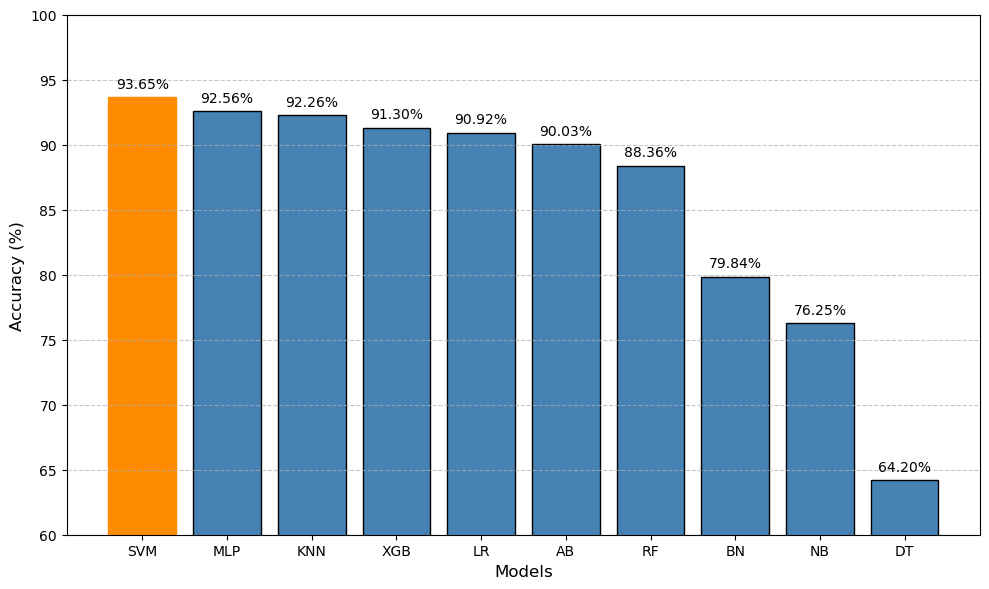

In [361]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = [
    "SVM", "MLP", "KNN", "XGB", "LR",
    "AB", "RF", "BN", "NB", "DT"
]
accuracies = [
    93.65, 92.56, 92.26, 91.30, 90.92,
    90.03, 88.36, 79.84, 76.25, 64.20
]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='steelblue', edgecolor='black')

# Highlight top performer
bars[0].set_color('darkorange')  # SVM

# Labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("figure4",dpi=300)
plt.show()


In [363]:
for i, label in enumerate(classes):
    print(f"Class {i} → {label}")

Class 0 → battery
Class 1 → biological
Class 2 → cardboard
Class 3 → clothes
Class 4 → glass
Class 5 → metal
Class 6 → paper
Class 7 → plastic
Class 8 → shoes
Class 9 → trash


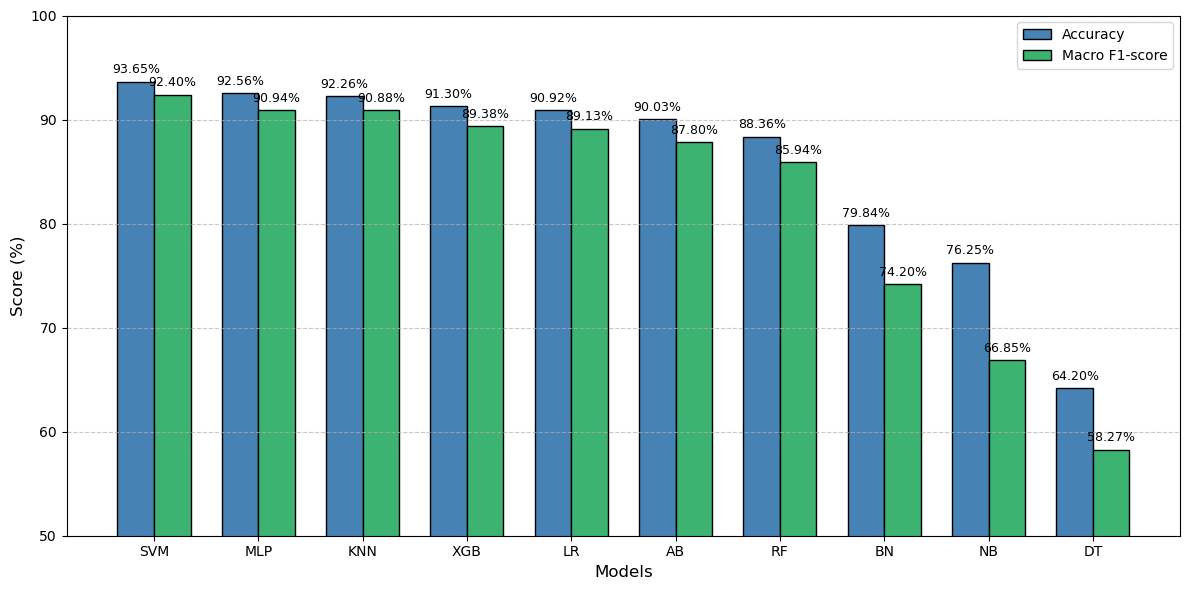

In [364]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "SVM", "MLP", "KNN", "XGB", "LR",
    "AB", "RF", "BN", "NB", "DT"
]

# Accuracy and Macro F1 scores
accuracy = [93.65, 92.56, 92.26, 91.30, 90.92, 90.03, 88.36, 79.84, 76.25, 64.20]
macro_f1 = [92.40, 90.94, 90.88, 89.38, 89.13, 87.80, 85.94, 74.20, 66.85, 58.27]

# Bar setup
x = np.arange(len(models))
width = 0.35  # Width of each bar

plt.figure(figsize=(12, 6))
acc_bars = plt.bar(x - width/2, accuracy, width, label='Accuracy', color='steelblue', edgecolor='black')
f1_bars = plt.bar(x + width/2, macro_f1, width, label='Macro F1-score', color='mediumseagreen', edgecolor='black')


# Labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)
plt.xticks(x, models)
plt.ylim(50, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate bars
for bar in acc_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

for bar in f1_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("figure4_accuracy_macroF1.png", dpi=300)
plt.show()

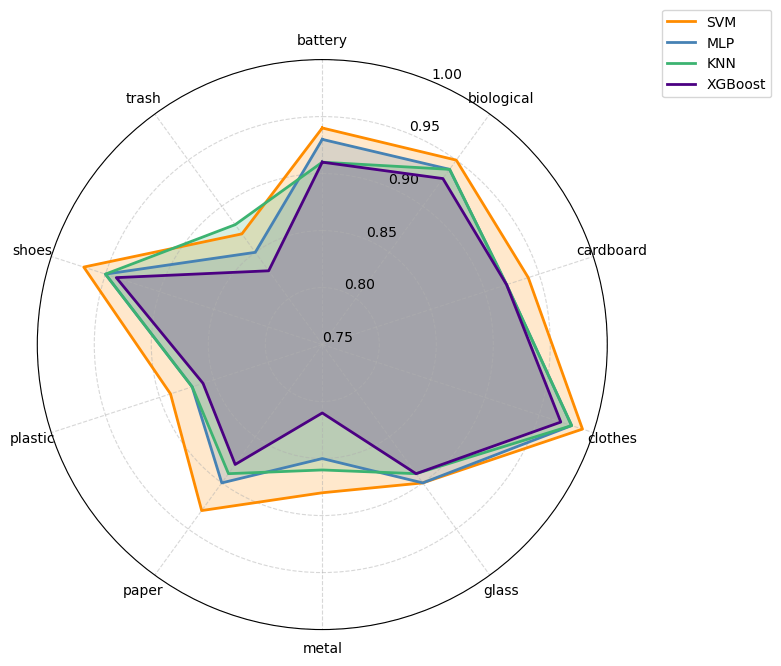

In [365]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
classes = [
    "battery", "biological", "cardboard", "clothes", "glass",
    "metal", "paper", "plastic", "shoes", "trash"
]

# F1-scores for each model
svm = [0.94, 0.95, 0.94, 0.99, 0.90, 0.88, 0.93, 0.89, 0.97, 0.87]
mlp = [0.93, 0.94, 0.92, 0.98, 0.90, 0.85, 0.90, 0.87, 0.95, 0.85]
knn = [0.91, 0.94, 0.92, 0.98, 0.89, 0.86, 0.89, 0.87, 0.95, 0.88]
xgb = [0.91, 0.93, 0.92, 0.97, 0.89, 0.81, 0.88, 0.86, 0.94, 0.83]

# Setup for radar chart
labels = np.array(classes)
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Append first value to close the radar chart
def close_loop(values):
    return values + values[:1]

svm = close_loop(svm)
mlp = close_loop(mlp)
knn = close_loop(knn)
xgb = close_loop(xgb)

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, svm, label='SVM', color='darkorange', linewidth=2)
ax.fill(angles, svm, color='darkorange', alpha=0.2)

ax.plot(angles, mlp, label='MLP', color='steelblue', linewidth=2)
ax.fill(angles, mlp, color='steelblue', alpha=0.2)

ax.plot(angles, knn, label='KNN', color='mediumseagreen', linewidth=2)
ax.fill(angles, knn, color='mediumseagreen', alpha=0.2)

ax.plot(angles, xgb, label='XGBoost', color='indigo', linewidth=2)
ax.fill(angles, xgb, color='indigo', alpha=0.2)

# Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
ax.set_ylim(0.75, 1.0)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig("figure6_radar_f1_scores.png", dpi=300)
plt.show()